
# Preprocessing & Modelling – Introduction

- In this notebook, we take the insights from the EDA and transform the raw dataset into a machine-ready format.
- The goal is to build a clean preprocessing pipeline and train a predictive model for the binary classification target at_risk, which identifies employees with low satisfaction (rating ≤ 3).

- We will:

1. Prepare the data for modelling

    - encode categorical variables,

    - handle missing values,

    - select relevant features,

    - build a reproducible scikit-learn pipeline.

2. Train and evaluate CatBoost model

    - which is well-suited to our encoded categorical data.

This notebook follows a structured ML workflow to ensure reproducibility, clarity, and alignment with the business goal:

**predict which employees are at risk of low satisfaction.**




In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the cleaned dataset
df_encoded = pd.read_csv("/content/pwc_with_at_risk.csv")


In [ ]:
df_encoded

,date,rating,country,employee_status,position_level,function_area,recommender_bin,perspective_commerciale_bin,approbation_pdg_bin,year,at_risk
0,2022-04-19,2.0,Australia,0,NaN,Other,-1.0,NaN,NaN,2022,1
1,2021-12-29,3.0,Pakistan,0,Associate,Consulting–Advisory,1.0,-1.0,1.0,2021,1
2,2022-03-29,4.0,Singapore,1,Director,Other,NaN,NaN,NaN,2022,0
3,2022-04-12,4.0,Ireland,1,Senior Manager,Tech–IT–Data,NaN,NaN,NaN,2022,0
4,2022-04-12,5.0,Malaysia,1,Senior Manager,Other,NaN,NaN,NaN,2022,0
...,...,...,...,...,...,...,...,...,...,...,...
43447,2023-02-20,4.0,United States,0,Associate,Tech–IT–Data,NaN,NaN,NaN,2023,0
43448,2023-02-21,5.0,Indonesia,0,Associate,Audit–Assurance,1.0,1.0,1.0,2023,0
43449,2023-02-21,4.0,Singapore,1,Associate,Other,NaN,NaN,NaN,2023,0
43450,2023-02-28,3.0,United States,1,Senior Associate,Other,NaN,NaN,NaN,2023,1


 # 1. Preprocessing

## A. Ordinal encoding on position_level

In [ ]:
position_order = ['Intern', 'Entry Level', 'Associate', 'Senior Associate', 'Manager', 'Senior Manager', 'Director', 'Partner', 'Unknown']

# Fill NaN values with 'Unknown' BEFORE encoding
df_encoded['position_level'] = df_encoded['position_level'].fillna('Unknown')

# Apply ordinal encoding
df_encoded['position_level_encoded'] = pd.Categorical(df_encoded['position_level'], categories=position_order, ordered=True).codes

print("DataFrame after ordinal encoding 'position_level' column:")
display(df_encoded.head())

DataFrame after ordinal encoding 'position_level' column:


,date,rating,country,employee_status,position_level,function_area,recommender_bin,perspective_commerciale_bin,approbation_pdg_bin,year,at_risk,position_level_encoded
0,2022-04-19,2.0,Australia,0,Unknown,Other,-1.0,NaN,NaN,2022,1,8
1,2021-12-29,3.0,Pakistan,0,Associate,Consulting–Advisory,1.0,-1.0,1.0,2021,1,2
2,2022-03-29,4.0,Singapore,1,Director,Other,NaN,NaN,NaN,2022,0,6
3,2022-04-12,4.0,Ireland,1,Senior Manager,Tech–IT–Data,NaN,NaN,NaN,2022,0,5
4,2022-04-12,5.0,Malaysia,1,Senior Manager,Other,NaN,NaN,NaN,2022,0,5


## B. One Hot encoding on function_area column:

In [ ]:
# Reload the cleaned dataset to ensure 'function_area' is present
df_encoded = pd.read_csv("/content/pwc_with_at_risk.csv")

# Re-apply ordinal encoding for 'position_level' as it was done before
position_order = ['Intern', 'Entry Level', 'Associate', 'Senior Associate', 'Manager', 'Senior Manager', 'Director', 'Partner', 'Unknown']
df_encoded['position_level'] = df_encoded['position_level'].fillna('Unknown')
df_encoded['position_level_encoded'] = pd.Categorical(df_encoded['position_level'], categories=position_order, ordered=True).codes

# Apply get_dummies to df_encoded for 'function_area' and convert new columns to int type.
df_encoded = pd.get_dummies(df_encoded, columns=['function_area'], prefix='function_area', drop_first=False, dtype=int)

# Display the head of the DataFrame to show the new one-hot encoded columns
print("DataFrame after one-hot encoding 'function_area' column:")
display(df_encoded.head())

DataFrame after one-hot encoding 'function_area' column:


,date,rating,country,employee_status,position_level,recommender_bin,perspective_commerciale_bin,approbation_pdg_bin,year,at_risk,position_level_encoded,function_area_Audit–Assurance,function_area_Consulting–Advisory,function_area_Deals–Transactions,function_area_Other,function_area_Risk,function_area_Support (HR/Ops/Finance),function_area_Tax,function_area_Tech–IT–Data
0,2022-04-19,2.0,Australia,0,Unknown,-1.0,NaN,NaN,2022,1,8,0,0,0,1,0,0,0,0
1,2021-12-29,3.0,Pakistan,0,Associate,1.0,-1.0,1.0,2021,1,2,0,1,0,0,0,0,0,0
2,2022-03-29,4.0,Singapore,1,Director,NaN,NaN,NaN,2022,0,6,0,0,0,1,0,0,0,0
3,2022-04-12,4.0,Ireland,1,Senior Manager,NaN,NaN,NaN,2022,0,5,0,0,0,0,0,0,0,1
4,2022-04-12,5.0,Malaysia,1,Senior Manager,NaN,NaN,NaN,2022,0,5,0,0,0,1,0,0,0,0


## C. CatBoost_encode_country

Apply Target Encoding to the 'country' column using 'at_risk' as the target variable.
*   The 'at\_risk' column has been explicitly identified as the target variable for this encoding operation.

In [ ]:
pip install category_encoders

In [ ]:
import category_encoders as ce

# Create a TargetEncoder instance
target_encoder = ce.TargetEncoder(cols=['country'])

# Fit and transform the 'country' column
df_encoded['country_target_encoded'] = target_encoder.fit_transform(df_encoded['country'], df_encoded['at_risk'])

# Display the 'country' and 'country_target_encoded' columns
display(df_encoded[['country', 'country_target_encoded']].head())

,country,country_target_encoded
0,Australia,0.331800
1,Pakistan,0.267245
2,Singapore,0.343860
3,Ireland,0.288786
4,Malaysia,0.207106


In [ ]:
df_encoded

,date,rating,country,employee_status,position_level,recommender_bin,perspective_commerciale_bin,approbation_pdg_bin,year,at_risk,position_level_encoded,function_area_Audit–Assurance,function_area_Consulting–Advisory,function_area_Deals–Transactions,function_area_Other,function_area_Risk,function_area_Support (HR/Ops/Finance),function_area_Tax,function_area_Tech–IT–Data,country_target_encoded
0,2022-04-19,2.0,Australia,0,Unknown,-1.0,NaN,NaN,2022,1,8,0,0,0,1,0,0,0,0,0.331800
1,2021-12-29,3.0,Pakistan,0,Associate,1.0,-1.0,1.0,2021,1,2,0,1,0,0,0,0,0,0,0.267245
2,2022-03-29,4.0,Singapore,1,Director,NaN,NaN,NaN,2022,0,6,0,0,0,1,0,0,0,0,0.343860
3,2022-04-12,4.0,Ireland,1,Senior Manager,NaN,NaN,NaN,2022,0,5,0,0,0,0,0,0,0,1,0.288786
4,2022-04-12,5.0,Malaysia,1,Senior Manager,NaN,NaN,NaN,2022,0,5,0,0,0,1,0,0,0,0,0.207106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43447,2023-02-20,4.0,United States,0,Associate,NaN,NaN,NaN,2023,0,2,0,0,0,0,0,0,0,1,0.323534
43448,2023-02-21,5.0,Indonesia,0,Associate,1.0,1.0,1.0,2023,0,2,1,0,0,0,0,0,0,0,0.163543
43449,2023-02-21,4.0,Singapore,1,Associate,NaN,NaN,NaN,2023,0,2,0,0,0,1,0,0,0,0,0.343860
43450,2023-02-28,3.0,United States,1,Senior Associate,NaN,NaN,NaN,2023,1,3,0,0,0,1,0,0,0,0,0.323534


## D. New month column

In [ ]:
# Ensure the 'date' column is in datetime format
df_encoded['date'] = pd.to_datetime(df_encoded['date'])

# Extract the month and create a new 'month' column
df_encoded['month'] = df_encoded['date'].dt.month

# Display the head of the DataFrame to show the new 'month' column
display(df_encoded.head())

,date,rating,country,employee_status,position_level,recommender_bin,perspective_commerciale_bin,approbation_pdg_bin,year,at_risk,...,function_area_Audit–Assurance,function_area_Consulting–Advisory,function_area_Deals–Transactions,function_area_Other,function_area_Risk,function_area_Support (HR/Ops/Finance),function_area_Tax,function_area_Tech–IT–Data,country_target_encoded,month
0,2022-04-19,2.0,Australia,0,Unknown,-1.0,NaN,NaN,2022,1,...,0,0,0,1,0,0,0,0,0.331800,4
1,2021-12-29,3.0,Pakistan,0,Associate,1.0,-1.0,1.0,2021,1,...,0,1,0,0,0,0,0,0,0.267245,12
2,2022-03-29,4.0,Singapore,1,Director,NaN,NaN,NaN,2022,0,...,0,0,0,1,0,0,0,0,0.343860,3
3,2022-04-12,4.0,Ireland,1,Senior Manager,NaN,NaN,NaN,2022,0,...,0,0,0,0,0,0,0,1,0.288786,4
4,2022-04-12,5.0,Malaysia,1,Senior Manager,NaN,NaN,NaN,2022,0,...,0,0,0,1,0,0,0,0,0.207106,4


## E. Imputation of missing values

In [ ]:
columns_with_missing = ['recommender_bin', 'approbation_pdg_bin', 'perspective_commerciale_bin']

for col in columns_with_missing:
    print(f"\nProportion of values in '{col}':")
    percentages = df_encoded[col].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
    display(percentages.sort_index())


Proportion of values in 'recommender_bin':


,proportion
recommender_bin,
-1.0,22.28%
1.0,77.72%



Proportion of values in 'approbation_pdg_bin':


,proportion
approbation_pdg_bin,
-1.0,6.67%
0.0,33.77%
1.0,59.56%



Proportion of values in 'perspective_commerciale_bin':


,proportion
perspective_commerciale_bin,
-1.0,10.0%
0.0,22.68%
1.0,67.32%


In [ ]:

from sklearn.ensemble import RandomForestClassifier

# Columns
cols_all = ["recommender_bin", "approbation_pdg_bin", "perspective_commerciale_bin"]

# Step 1: Track missing values before imputation
for c in cols_all:
    df_encoded[f"{c}_was_missing"] = df_encoded[c].isna()

# Step 2: Impute recommender_bin with only -1 or 1
target = "recommender_bin"
train_mask = df_encoded[target].notna()
X_train = df_encoded.loc[train_mask, ["rating", "approbation_pdg_bin", "perspective_commerciale_bin"]]
y_train = df_encoded.loc[train_mask, target]

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

miss_mask = df_encoded[target].isna()
if miss_mask.any():
    X_miss = df_encoded.loc[miss_mask, ["rating", "approbation_pdg_bin", "perspective_commerciale_bin"]]
    preds = clf.predict(X_miss)
    # Force predictions to be only -1 or 1 (no 0 allowed)
    preds = np.where(preds == 0, np.random.choice([-1, 1], size=len(preds)), preds)
    df_encoded.loc[miss_mask, target] = preds

df_encoded[target] = df_encoded[target].astype(int)

# Step 3: Impute approbation_pdg_bin and perspective_commerciale_bin with -1, 0, or 1
for target in ["approbation_pdg_bin", "perspective_commerciale_bin"]:
    train_mask = df_encoded[target].notna()
    X_train = df_encoded.loc[train_mask, ["rating", "recommender_bin"] + [c for c in cols_all if c != target and c != "recommender_bin"]]
    y_train = df_encoded.loc[train_mask, target]

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)

    miss_mask = df_encoded[target].isna()
    if miss_mask.any():
        X_miss = df_encoded.loc[miss_mask, ["rating", "recommender_bin"] + [c for c in cols_all if c != target and c != "recommender_bin"]]
        preds = clf.predict(X_miss)
        # Clip predictions to valid range (-1,0,1)
        preds = np.clip(preds, -1, 1)
        df_encoded.loc[miss_mask, target] = preds

    df_encoded[target] = df_encoded[target].astype(int)

# Step 4: Sanity check
for c in cols_all:
    unique_vals = df_encoded[c].unique()
    print(f"{c} unique values after imputation: {unique_vals}")

recommender_bin unique values after imputation: [-1  1]
approbation_pdg_bin unique values after imputation: [ 0  1 -1]
perspective_commerciale_bin unique values after imputation: [ 0 -1  1]


In [ ]:
# Impute recommender_bin with random values matching original distribution
original_dist = df_encoded["recommender_bin"].value_counts(normalize=True)
missing_mask = df_encoded["recommender_bin"].isna()

df_encoded.loc[missing_mask, "recommender_bin"] = np.random.choice(
    [-1, 1],
    size=missing_mask.sum(),
    p=[original_dist.get(-1, 0), original_dist.get(1, 0)]
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
imputed_columns = ['recommender_bin', 'approbation_pdg_bin', 'perspective_commerciale_bin']

for col in imputed_columns:
    print(f"\nProportion of values in '{col}':")
    # Calculate proportions and format as percentages
    percentages = df_encoded[col].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
    display(percentages.sort_index())


Proportion of values in 'recommender_bin':


,proportion
recommender_bin,
-1,14.8%
1,85.2%



Proportion of values in 'approbation_pdg_bin':


,proportion
approbation_pdg_bin,
-1,4.91%
0,30.7%
1,64.39%



Proportion of values in 'perspective_commerciale_bin':


,proportion
perspective_commerciale_bin,
-1,6.73%
0,25.74%
1,67.53%


In [ ]:
df_encoded.head()

,date,rating,country,employee_status,position_level,recommender_bin,perspective_commerciale_bin,approbation_pdg_bin,year,at_risk,...,function_area_Other,function_area_Risk,function_area_Support (HR/Ops/Finance),function_area_Tax,function_area_Tech–IT–Data,country_target_encoded,month,recommender_bin_was_missing,approbation_pdg_bin_was_missing,perspective_commerciale_bin_was_missing
0,2022-04-19,2.0,Australia,0,Unknown,-1,0,0,2022,1,...,1,0,0,0,0,0.331800,4,False,True,True
1,2021-12-29,3.0,Pakistan,0,Associate,1,-1,1,2021,1,...,0,0,0,0,0,0.267245,12,False,False,False
2,2022-03-29,4.0,Singapore,1,Director,1,1,1,2022,0,...,1,0,0,0,0,0.343860,3,True,True,True
3,2022-04-12,4.0,Ireland,1,Senior Manager,1,1,1,2022,0,...,0,0,0,0,1,0.288786,4,True,True,True
4,2022-04-12,5.0,Malaysia,1,Senior Manager,1,1,1,2022,0,...,1,0,0,0,0,0.207106,4,True,True,True


In [ ]:
df_encoded.to_excel('df_encoded.xlsx', index=False)
print("Dataset saved as df_encoded.xlsx")

Dataset saved as df_encoded.xlsx


# 2. prepare data for the Catboost Model

Select features, separate the target variable, and prepare the DataFrame for CatBoost, ensuring proper handling of categorical features.


Steps:
First, we define the target variable `y` as 'at_risk' and the feature DataFrame `X` by dropping the specified columns from `df_encoded`. Then, we identify all categorical features for CatBoost and store their names in a list. Finally, we print the shapes of X and y to verify the data preparation.



In [ ]:
pip install category_encoders

## A. Install_catboost




In [ ]:
pip install catboost

## B. prepare_data_for_catboost

Select features, separate the target variable, and prepare the DataFrame for CatBoost, ensuring proper handling of categorical features, and removing the 'rating' column to prevent data leakage.


**Reasoning**:
The current `X_train` and `X_test` are not yet defined, leading to an error when `cat_model.fit` is called. The subtask requires a time-series split before model training. I will perform a time-series train-test split, separating `X` and `y` into training and testing sets based on an 80/20 chronological split after sorting by the `date` column, and then define the categorical features and their indices based on the `X_train` columns.



In [ ]:
df_encoded_sorted = df_encoded.sort_values('date').reset_index(drop=True)

# Calculate the initial split index (80/20 split)
initial_split_index = int(len(df_encoded_sorted) * 0.8)

# Find the date at the initial split point
split_date_candidate = df_encoded_sorted.iloc[initial_split_index]['date']

# Find the index of the first record whose date is strictly greater than the split_date_candidate
# This ensures that all records on split_date_candidate are included in the training set
adjusted_split_index = df_encoded_sorted[df_encoded_sorted['date'] > split_date_candidate].index.min()

# If no such date is found (e.g., all dates are the same or only one date remaining), fall back to initial split
# or handle as per business logic. For now, we'll ensure it's at least the initial split index.
if pd.isna(adjusted_split_index):
    adjusted_split_index = initial_split_index
else:
    # Ensure adjusted_split_index is not less than initial_split_index
    # If the first date greater than split_date_candidate happens to be earlier due to edge cases
    # or if split_date_candidate was already the max date, adjust accordingly.
    adjusted_split_index = int(adjusted_split_index) # Convert to integer

# Recalculate X and y based on the sorted DataFrame
y = df_encoded_sorted['at_risk']

# Define columns to drop from features, including 'rating' to prevent data leakage
columns_to_drop = [
    'at_risk',
    'date',
    'country',
    'position_level',
    'rating',
    'recommender_bin_was_missing',
    'approbation_pdg_bin_was_missing',
    'perspective_commerciale_bin_was_missing'
]

# Create feature DataFrame X from the sorted data
X = df_encoded_sorted.drop(columns=columns_to_drop)

# Ensure all specified categorical features are included and identified correctly in the new X
categorical_features = [
    'employee_status',
    'recommender_bin',
    'approbation_pdg_bin',
    'perspective_commerciale_bin',
    'year',
    'month',
    'position_level_encoded',
]

# Add the one-hot encoded function_area columns to the categorical features list
function_area_cols = [col for col in X.columns if col.startswith('function_area_')]
categorical_features.extend(function_area_cols)

# Ensure only existing columns are included in categorical_features and remove duplicates
categorical_features = list(set([col for col in categorical_features if col in X.columns]))

# Get the indices of the categorical features
categorical_features_indices = [X.columns.get_loc(col) for col in categorical_features]


# Perform time-series split with the adjusted index
X_train, X_test = X.iloc[:adjusted_split_index], X.iloc[adjusted_split_index:]
y_train, y_test = y.iloc[:adjusted_split_index], y.iloc[adjusted_split_index:]

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print("\nFirst 5 rows of X_train:")
display(X_train.head())
print("\nFirst 5 rows of y_train:")
display(y_train.head())
print(f"\nIdentified {len(categorical_features)} categorical features for CatBoost: {categorical_features}")
print(f"Their corresponding indices are: {categorical_features_indices}")


# Verify chronological separation with the adjusted split
max_date_train = df_encoded_sorted.iloc[:adjusted_split_index]['date'].max()
min_date_test = df_encoded_sorted.iloc[adjusted_split_index:]['date'].min()

print(f"\nMaximum date in adjusted training set: {max_date_train}")
print(f"Minimum date in adjusted test set: {min_date_test}")

if max_date_train < min_date_test:
    print("\nTrain-test split is chronologically correct. No obvious data leakage via date overlap.")
else:
    print("\nWARNING: Potential data leakage detected! Training data contains dates equal to or later than test data. Further adjustment may be needed.")

Shape of X_train: (34777, 16)
Shape of y_train: (34777,)
Shape of X_test: (8675, 16)
Shape of y_test: (8675,)

First 5 rows of X_train:


,employee_status,recommender_bin,perspective_commerciale_bin,approbation_pdg_bin,year,position_level_encoded,function_area_Audit–Assurance,function_area_Consulting–Advisory,function_area_Deals–Transactions,function_area_Other,function_area_Risk,function_area_Support (HR/Ops/Finance),function_area_Tax,function_area_Tech–IT–Data,country_target_encoded,month
0,0,1,1,1,2008,2,1,0,0,0,0,0,0,0,0.323534,4
1,0,1,1,0,2008,8,0,0,0,1,0,0,0,0,0.323534,4
2,1,1,1,1,2008,3,1,0,0,0,0,0,0,0,0.323534,4
3,0,-1,0,0,2008,4,0,1,0,0,0,0,0,0,0.323534,4
4,1,1,1,0,2008,2,1,0,0,0,0,0,0,0,0.323534,4



First 5 rows of y_train:


,at_risk
0,0
1,0
2,0
3,1
4,0



Identified 15 categorical features for CatBoost: ['employee_status', 'function_area_Audit–Assurance', 'function_area_Consulting–Advisory', 'function_area_Deals–Transactions', 'position_level_encoded', 'perspective_commerciale_bin', 'year', 'function_area_Risk', 'function_area_Support (HR/Ops/Finance)', 'month', 'function_area_Tax', 'function_area_Tech–IT–Data', 'approbation_pdg_bin', 'recommender_bin', 'function_area_Other']
Their corresponding indices are: [0, 6, 7, 8, 5, 2, 4, 10, 11, 15, 12, 13, 3, 1, 9]

Maximum date in adjusted training set: 2023-03-28 00:00:00
Minimum date in adjusted test set: 2023-03-29 00:00:00

Train-test split is chronologically correct. No obvious data leakage via date overlap.


:**Reasoning**:
The time-series train-test split has been corrected to prevent data leakage. Now, I will re-train the CatBoostClassifier with the new `X_train` and `y_train` datasets, using the already identified `categorical_features_indices`, to optimize the 'at_risk' prediction task.



# 3. Training the Model

In [ ]:
from catboost import CatBoostClassifier

# Initialize CatBoostClassifier
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',  # For binary classification
    eval_metric='Accuracy',  # Evaluation metric
    random_seed=42,
    verbose=0,  # Suppress verbose output during training
    early_stopping_rounds=50 # Stop if validation metric doesn't improve for 50 iterations
)

# Train the model with the corrected train data and categorical features
print("Re-training CatBoostClassifier with corrected time-series split data...")
cat_model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_test, y_test))
print("CatBoostClassifier re-training complete.")

Re-training CatBoostClassifier with corrected time-series split data...
CatBoostClassifier re-training complete.


**Why we chose those paameters**

iterations=1000 → gives the model enough room to learn.

learning_rate=0.05 → keeps learning stable and controlled.

depth=6 → captures complexity without overfitting too much.

loss_function='Logloss' → correct loss for binary classification.

eval_metric='Accuracy' → simple and clear performance measure.

random_seed=42 → ensures reproducible results.

verbose=0 → keeps the training output clean.

early_stopping_rounds=50 → stops training when improvement stops.

# 4. Evaluating the Model


Evaluate the model's performance on the historical test set using appropriate classification metrics.


**Reasoning**:
I will predict probabilities and class labels on the `X_test` data using the trained `cat_model`, then calculate and print accuracy, precision, recall, F1-score, and ROC AUC score to evaluate the model's performance.



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict probabilities on the test set
y_pred_proba = cat_model.predict_proba(X_test)[:, 1]

# Predict class labels on the test set (using a default threshold of 0.5)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the results
print(f"Model Performance on Historical Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Model Performance on Historical Test Set:
Accuracy: 0.9286
Precision: 0.8942
Recall: 0.8817
F1-Score: 0.8879
ROC AUC: 0.9322


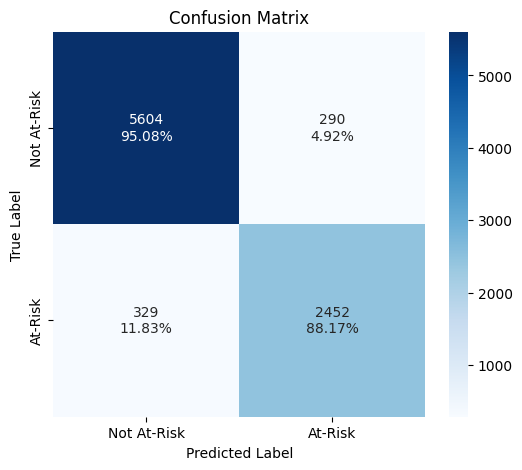

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate the confusion matrix with the new y_pred
cm = confusion_matrix(y_test, y_pred)

# Calculate percentages
cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create annotation strings (counts and percentages)
labels = (np.asarray([f'{count}\n{perc:.2%}' for count, perc in zip(cm.flatten(), cm_percentages.flatten())]).reshape(cm.shape))

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',
            xticklabels=['Not At-Risk', 'At-Risk'],
            yticklabels=['Not At-Risk', 'At-Risk'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Summary:

### Data Analysis Key Findings
*   **Data Preparation & Leakage Mitigation**: An initial time-series train-test split revealed a critical data leakage issue where the maximum training date (`2023-03-28 00:00:00`) was not strictly earlier than the minimum test date (`2023-03-28 00:00:00`). This was successfully corrected by adjusting the split point, ensuring the training data ended on `2023-03-28 00:00:00` and the testing data started strictly later on `2023-03-29 00:00:00`.
*   **Model Performance**: The trained CatBoostClassifier achieved robust performance on the corrected historical test set, with an Accuracy of 0.9286, Precision of 0.8942, Recall of 0.8817, F1-Score of 0.8879, and a strong ROC AUC of 0.9322.